# CTE

In [1]:
import pandas as pd, numpy as np, scipy, re, seaborn as sns, random, pysam, sklearn, glob
sns.set()
import itertools as it
from scipy import stats, integrate, cluster
from scipy.stats import entropy, spearmanr, ttest_ind, zscore
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.manifold import TSNE
from matplotlib_venn import venn2, venn3, venn3_circles, venn3_unweighted
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from __future__ import print_function
import time

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/Mojito/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['entropy', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Dataset to make the info file

```python
cell_markers = pd.read_csv('RNASeq_cases_cell_type_markers.csv',sep=',')

CTE_info = pd.read_csv('CTE_sample_info.csv', sep=',', usecols=['ID','Status','SampleName','RIN', 'Seq_Batch'])
print(len(CTE_info), len(cell_markers))
CTE_info['SampleName'] = CTE_info['SampleName'].str.replace('TS-','')
CTE_info = pd.merge(CTE_info, cell_markers, left_on='SampleName', right_on='Case ID')
print(len(CTE_info))

CTE_info['SampleName']=['{}-{:04d}'.format(_.split('-')[0], int(_.split('-')[1])) if 'K' in _ else _ for _ in CTE_info['SampleName']]
CTE_info['SampleName']=[ _.replace('-','') if 'BVAX' in _ else _ for _ in CTE_info['SampleName']]

CTE_info['ID'] = CTE_info['ID'].str.split('_').str[0] + '_' + CTE_info['ID'].str.split('_').str[1]

CTE_info.head()

```

```python
u_info = pd.read_csv('RNASeqAnalysis_wDementiahx.csv', sep=',', 
                     usecols=['subjid', 'agedeath', 'CTEstage', 'DementiaHx','PathAD','PathLBD'
                             ,'agecogsx','afe' ,'totyrs' ,'Race_Self_Report','sport','footyrs'])
u_info['subjid'] =['BVAX{:03d}'.format(int(_.split('BVAX')[1])) if 'BVAX' in _ else _ for _ in u_info['subjid']]

info = pd.merge(CTE_info, u_info, left_on='SampleName', right_on='subjid', how='left')
info['PathLBD'] = [ '1' if _ == '0' else _ for _ in info['PathLBD']]
info = info.replace(r'\s+|^$', np.nan, regex=True)
info = info.replace(r'unk', np.nan, regex=True)
cols = list(info)[6:]
info[cols] = info[cols].apply(pd.to_numeric, errors='coerce')

info = info.drop(columns=['Case ID','subjid'])
# Drop ,'SampleName', 'subjid'
# Make changes
info.loc[30,'ID'] = 'CTEM_0031'
info.loc[30,'Status'] = 'CTE_12'
info.loc[30,'Diagnosis'] = 'CTEM'
info.loc[54,'ID'] = 'CTES_0055'
info.loc[54,'Status'] = 'CTE_34'
info.loc[54,'Diagnosis'] = 'CTES'
info2 = info.copy()
#info.to_csv('CTE_sample_info_all.csv', index=False)
```

In [2]:
info = pd.read_csv('CTE_sample_info_all.csv', sep=',')
#info_wocnt = info[(info['Status']== 'CTE_12') | (info['Status']== 'RHI')]
info = info[info['Status']!= 'CNT']
print(len(info[info['Status']== 'RHI']),len(info[info['Status']== 'CTE_12']),len(info[info['Status']== 'CTE_34']))
info[info['Status'] == 'RHI'][['ID','Status','totyrs','CTEstage','agedeath']]

10 13 53


ID Status  totyrs  CTEstage  agedeath
0   RHIN_0000    RHI    14.0       0.0        70
1   RHIN_0001    RHI     9.0       0.0        18
2   RHIN_0002    RHI     NaN       NaN        51
26  RHIN_0027    RHI    12.0       1.0        42
27  RHIN_0028    RHI     6.0       0.0        54
48  RHIN_0049    RHI    11.0       0.0        55
51  RHIN_0052    RHI    42.0       NaN        72
52  RHIN_0053    RHI     5.0       0.0        21
74  RHIN_0075    RHI     NaN       0.0        86
75  RHIN_0076    RHI    10.0       0.0        22

In [3]:
infom = info[~info['totyrs'].isnull()][['ID','Status','totyrs']]
#infom = infom[infom['totyrs']<30]
print(len(infom[infom['Status']=='RHI']),len(infom[infom['Status']=='CTE_12']),len(infom[infom['Status']=='CTE_34']))
#status = infom['Status'].unique().tolist()
#Q1 = infom.groupby('Status').quantile(0.25)['totyrs']
#Q3 = infom.groupby('Status').quantile(0.75)['totyrs']
#IQR = Q3 - Q1

#df = infom[infom['Status'] == status[1]]
#df = df[((df['totyrs'] < (Q1[status[0]] - 1.5 * IQR[status[0]]))|(df['totyrs'] > (Q3[status[0]] + 1.5 * IQR[status[0]])))]
#print(len(df))
#df


8 13 53


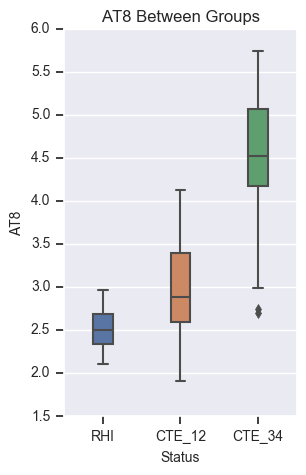

In [4]:
# plot boxplot with seaborn
cov = 'AT8'
plt.figure(figsize=(3,5))
bplot=sns.boxplot(y=cov, x='Status', 
                 data=info, 
                 width=0.25)
bplot.axes.set_title(cov+" Between Groups",fontsize=12)
bplot.set_xlabel("Status", fontsize=10)
bplot.set_ylabel(cov,fontsize=10)
bplot.tick_params(labelsize=10)
plt.tick_params(top='off', right='off', which='both')


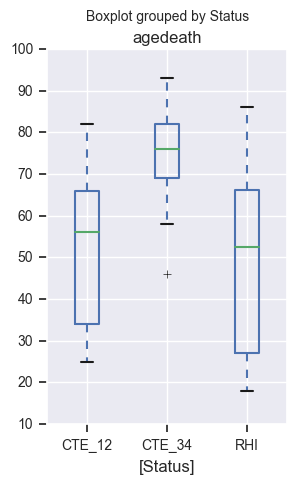

In [5]:
bp = info.boxplot(column=['agedeath'], by=['Status'], fontsize=10, figsize=(3,5), 
                  boxprops=dict(linestyle='-', linewidth=1.5),
                  medianprops=dict(linestyle='-', linewidth=1.5),
                  whiskerprops=dict(linestyle='--',linewidth=1.5),
                  capprops=dict(linestyle='-',linewidth=1.5))
#plt.setp(bp['fliers'], markersize=3.0)

plt.tick_params(top='off', right='off', which='both') 


#info.boxplot(column=['totyrs'], by=['Status'], fontsize=7)
#plt.tick_params(top='off', right='off', which='both') 
#plt.figure(figsize=(6,4))
#info.dropna(subset=['PathAD'])

/Users/Mojito/anaconda/lib/python3.5/site-packages/pandas/plotting/_core.py:2254: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  return_type=return_type, **kwds)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a242a35f8>,
      dtype=object)

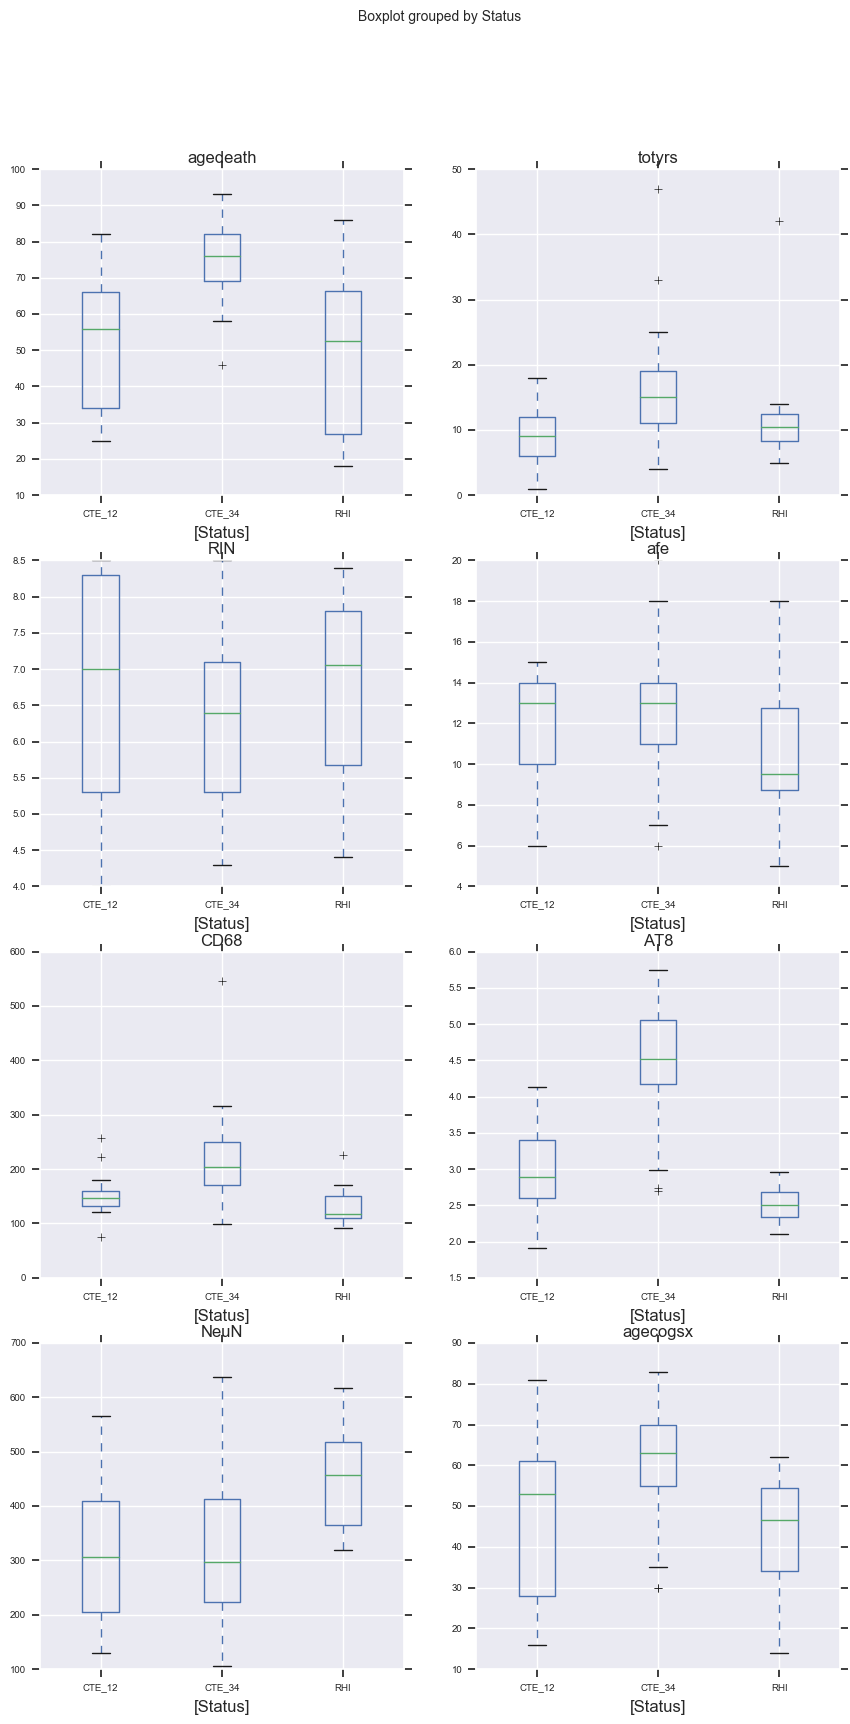

In [6]:
f, ax = plt.subplots(4,2, figsize=(10,20))
#sharex=True
info.boxplot(ax=ax, column=['agedeath','totyrs','RIN','afe','CD68', 'AT8', 'NeuN','agecogsx'], by=['Status'], fontsize=7)
#info.dropna(subset=['PathAD'])

In [6]:
cte34 = info[info['Status'] == 'CTE_34'][['ID', 'PathAD','PathLBD']]

print(len(cte34[(cte34['PathAD'] == 0) & (cte34['PathLBD'] == 1)]))
print(len(cte34[(cte34['PathAD'] == 0) & (cte34['PathLBD'] == 2)]))
print(len(cte34[(cte34['PathAD'] == 1) & (cte34['PathLBD'] == 1)]))
print(len(cte34[(cte34['PathAD'] == 1) & (cte34['PathLBD'] == 2)]))

pd.DataFrame({'LBD':['PathLBD = 1', 'PathLBD = 2'],
              'PathAD=0':[len(cte34[(cte34['PathAD'] == 0) & (cte34['PathLBD'] == 1)]),
                          len(cte34[(cte34['PathAD'] == 0) & (cte34['PathLBD'] == 2)])],
             'PathAD=1':[len(cte34[(cte34['PathAD'] == 1) & (cte34['PathLBD'] == 1)]),
                         len(cte34[(cte34['PathAD'] == 1) & (cte34['PathLBD'] == 2)])]}, columns=['LBD','PathAD=0','PathAD=1'])

28
7
16
2


LBD  PathAD=0  PathAD=1
0  PathLBD = 1        28        16
1  PathLBD = 2         7         2

/Users/Mojito/anaconda/lib/python3.5/site-packages/pandas/plotting/_core.py:2257: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  return_type=return_type, **kwds)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x125ed0c88>,
      dtype=object)

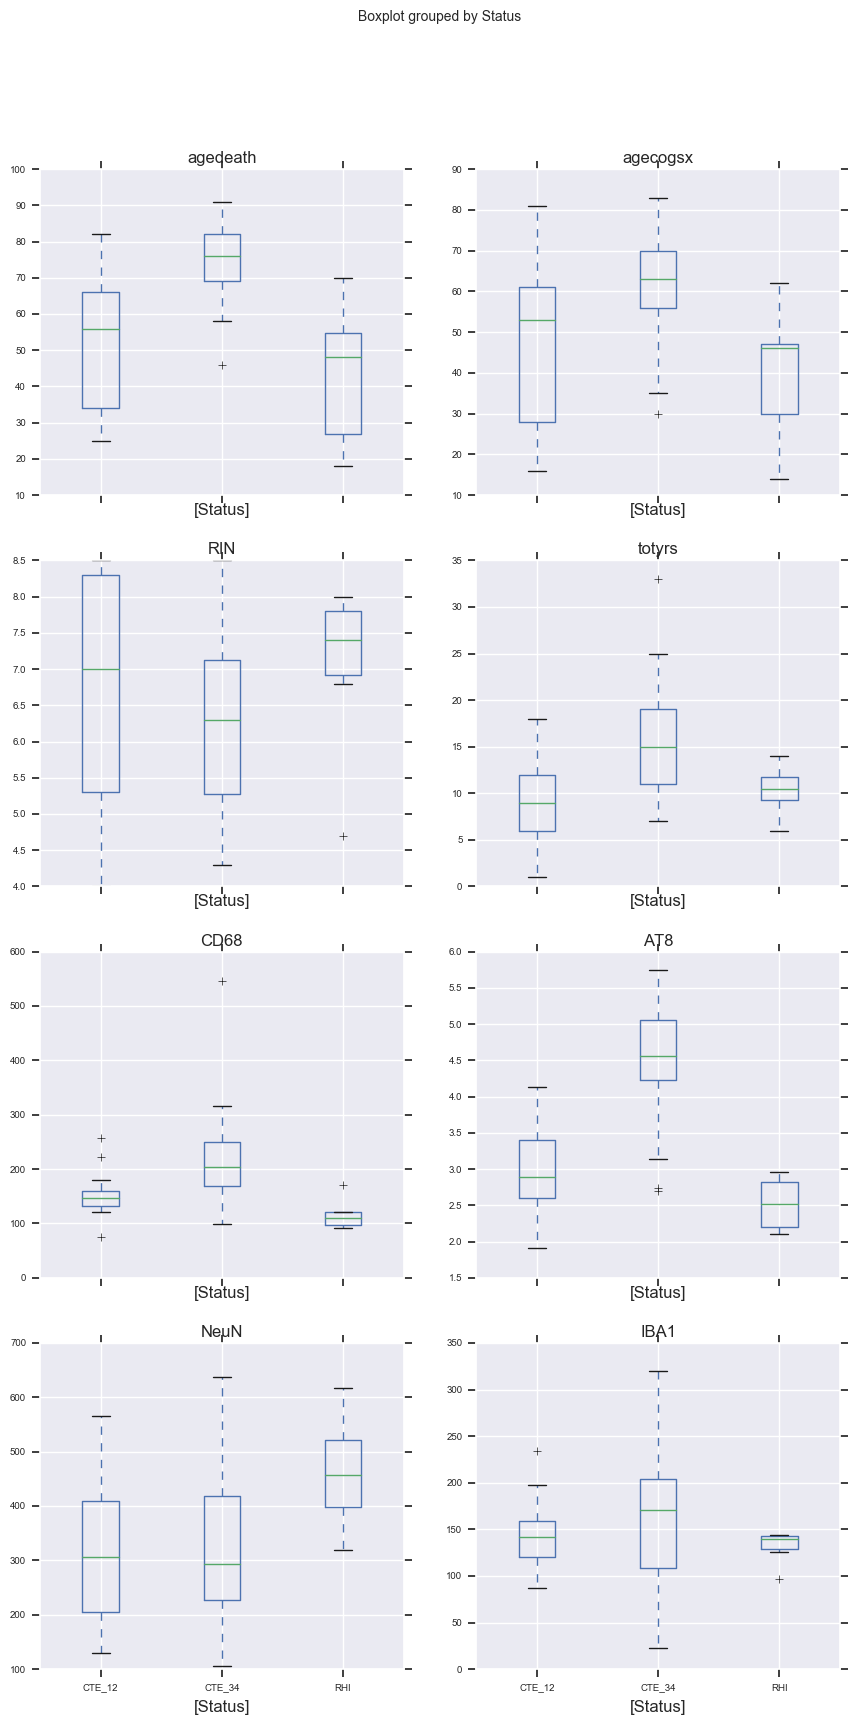

In [7]:
foot = info[info['sport'] == 1]
f, ax = plt.subplots(4,2,sharex=True, figsize=(10,20))
foot.boxplot(ax=ax, column=['agedeath','agecogsx','RIN','totyrs','CD68', 'AT8', 'NeuN','IBA1'], by=['Status'], fontsize=7)

In [8]:
info[info['Status']=='RHI']

ID Status SampleName  RIN Seq_Batch Diagnosis        CD68  \
0   RHIN_0000    RHI     K-0002  7.3        B1       RHI  110.852986   
1   RHIN_0001    RHI    SLI-117  7.5        B1       RHI   92.224600   
2   RHIN_0002    RHI    SLI-161  4.4        B1       RHI  226.464538   
26  RHIN_0027    RHI    SLI-116  6.8        B2       RHI   96.842562   
27  RHIN_0028    RHI    SLI-111  7.9        B2       RHI         NaN   
48  RHIN_0049    RHI     K-0038  4.7        B3       RHI  170.680222   
51  RHIN_0052    RHI    SLI-132  6.8        B3       RHI  116.932779   
52  RHIN_0053    RHI     K-0068  8.4        B3       RHI  115.118195   
74  RHIN_0075    RHI     K-0078  5.3        B4       RHI  150.113825   
75  RHIN_0076    RHI    SLI-121  8.0        B4       RHI  121.245209   

          IBA1       AT8        NeuN        ...         CTEstage  PathAD  \
0   141.136944  2.864408  616.677259        ...              0.0     0.0   
1   144.148885  2.101321         NaN        ...              0.0     0.0   
2          NaN  2.499779         NaN        ...              NaN     NaN   
26   96.421081  2.680935  489.493260        ...              1.0     0.0   
27  137.087369  2.361952         NaN        ...              0.0     0.0   
48  125.723783  2.962068  425.145712        ...              0.0     0.0   
51   89.810792  2.617289         NaN        ...              NaN     NaN   
52  119.698454  2.337452  527.988800        ...              0.0     0.0   
74  185.428071       NaN  345.105671        ...              0.0     0.0   
75  143.953495  2.154259  320.019835        ...              0.0     0.0   

    PathLBD  footyrs  agecogsx  totyrs   afe  sport  DementiaHx  \
0       1.0     14.0      62.0    14.0  12.0    1.0         1.0   
1       1.0      9.0       NaN     9.0   9.0    1.0         0.0   
2       NaN      NaN       NaN     NaN   NaN    NaN         0.0   
26      1.0     12.0      30.0    12.0   9.0    1.0         0.0   
27      1.0      6.0      47.0     6.0  10.0    1.0         0.0   
48      1.0     11.0      46.0    11.0   5.0    1.0         0.0   
51      NaN      NaN      57.0    42.0  18.0    6.0         0.0   
52      1.0      NaN       NaN     5.0  15.0    5.0         0.0   
74      1.0      NaN       NaN     NaN   NaN    NaN         1.0   
75      1.0     10.0      14.0    10.0   8.0    1.0         0.0   

    Race_Self_Report  
0                2.0  
1                1.0  
2                1.0  
26               NaN  
27               1.0  
48               1.0  
51               1.0  
52               7.0  
74               1.0  
75               1.0  

[10 rows x 21 columns]

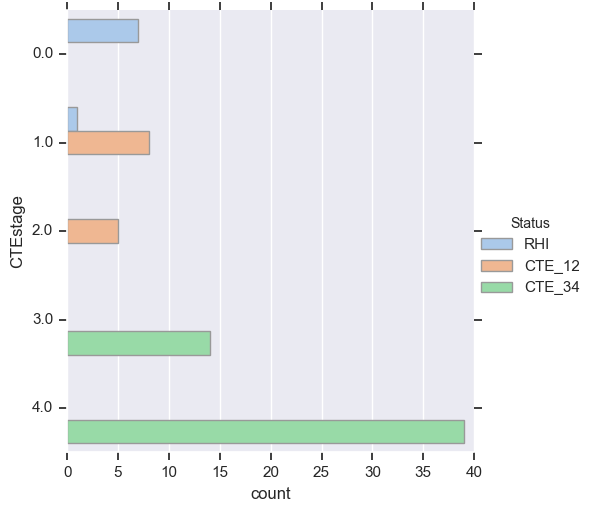

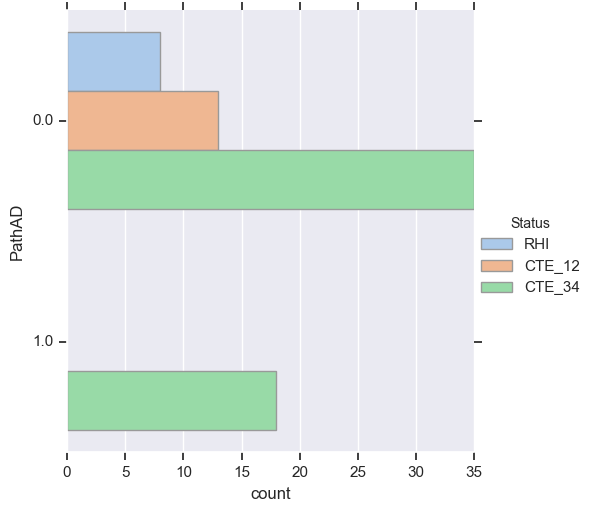

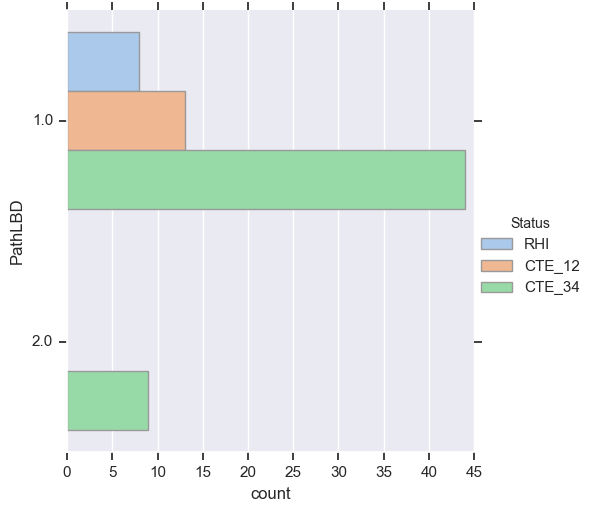

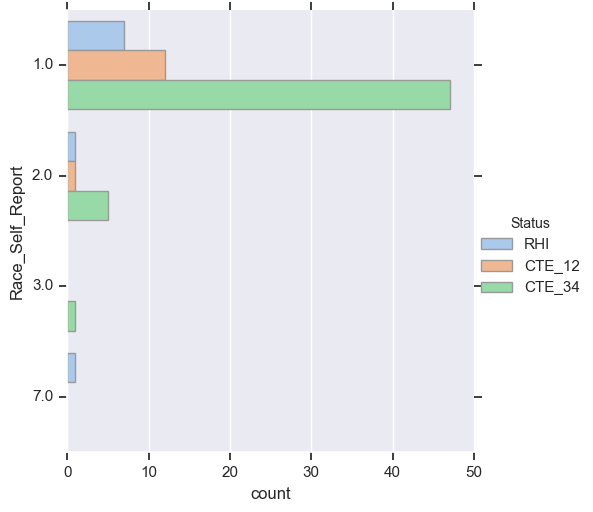

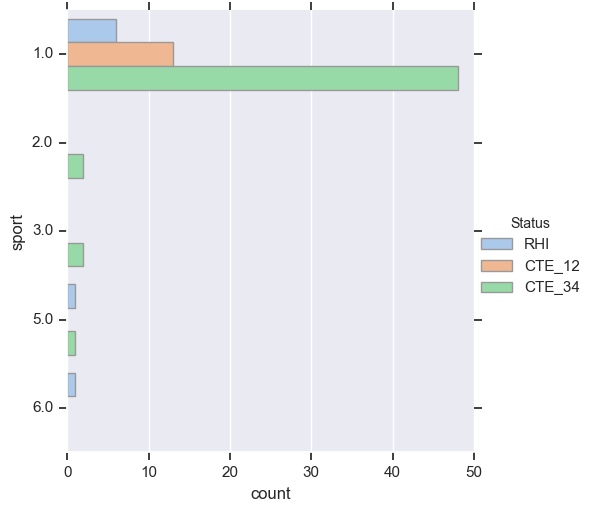

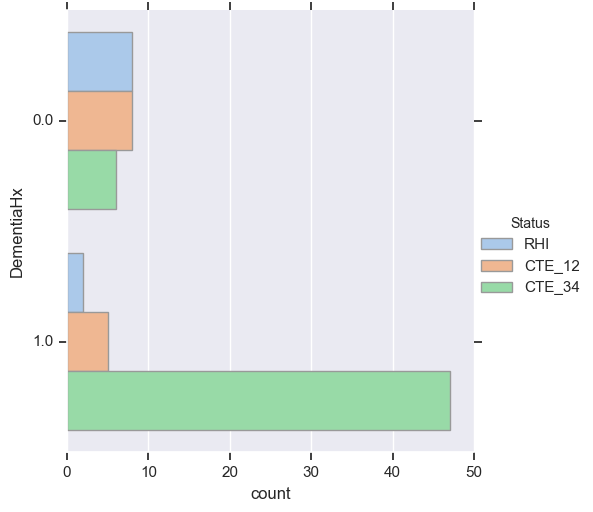

In [9]:
for column in [ 'CTEstage', 'PathAD','PathLBD','Race_Self_Report','sport','DementiaHx']:
    sns.catplot(y=column, hue="Status", kind="count",palette="pastel", edgecolor=".6",data=info);

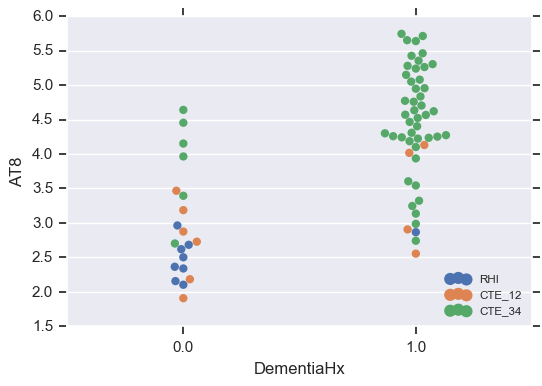

In [18]:
sns.swarmplot(x='DementiaHx', y='AT8', hue="Status",data=info, s=6)
plt.legend(loc='lower right', frameon=False, fontsize = 'small')
    

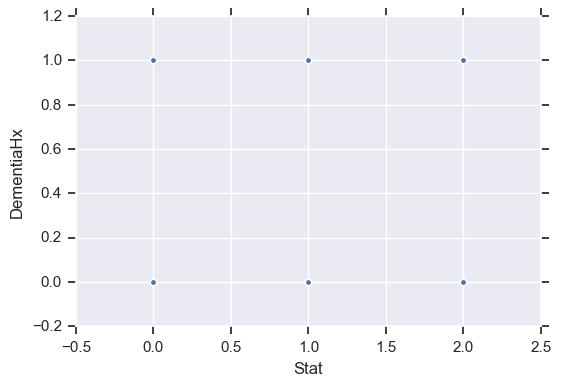

In [18]:
info['Stat'] = info['Status'].map(lambda x: 0 if 'RHI' in x else 1 if 'CTE_12'in x else 2)
info.plot( x='Stat',y='DementiaHx',kind='scatter')

## TSNE

In [20]:
from sklearn.datasets import fetch_mldata
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

In [21]:
norm = pd.read_csv('all_NumReads_counts_filtlow_all_norm.csv', sep=',', index_col='Name')
samples = list(norm)
x = norm.T
print(x.shape, len(samples), norm.shape)
genes = list(x)
x = x.merge(info, left_index=True, right_on='ID')
x = x.set_index(x['ID'])
x.index.name = None
x = x[x['Status'] != 'CNT']
print(x.shape, len(samples), norm.shape)

(85, 26538) 85 (26538, 85)
(74, 26560) 85 (26538, 85)


In [22]:
np.random.seed(42)

data = x[genes].values
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=5000)
tsne_results = tsne.fit_transform(data)
#print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 73 nearest neighbors...
[t-SNE] Indexed 74 samples in 0.002s...
[t-SNE] Computed neighbors for 74 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 74 / 74
[t-SNE] Mean sigma: 367837.448621
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.700905
[t-SNE] KL divergence after 3200 iterations: 0.105635


In [25]:
x['tsne-one'] = tsne_results[:,0]
x['tsne-two'] = tsne_results[:,1]

extra_cols = [ _ for _ in list(x) if 'ENSG' not in _ ]
rel_cols = ['Status','CTEstage','PathAD','PathLBD']
cont_cols = ['agedeath','RIN','agecogsx','totyrs']

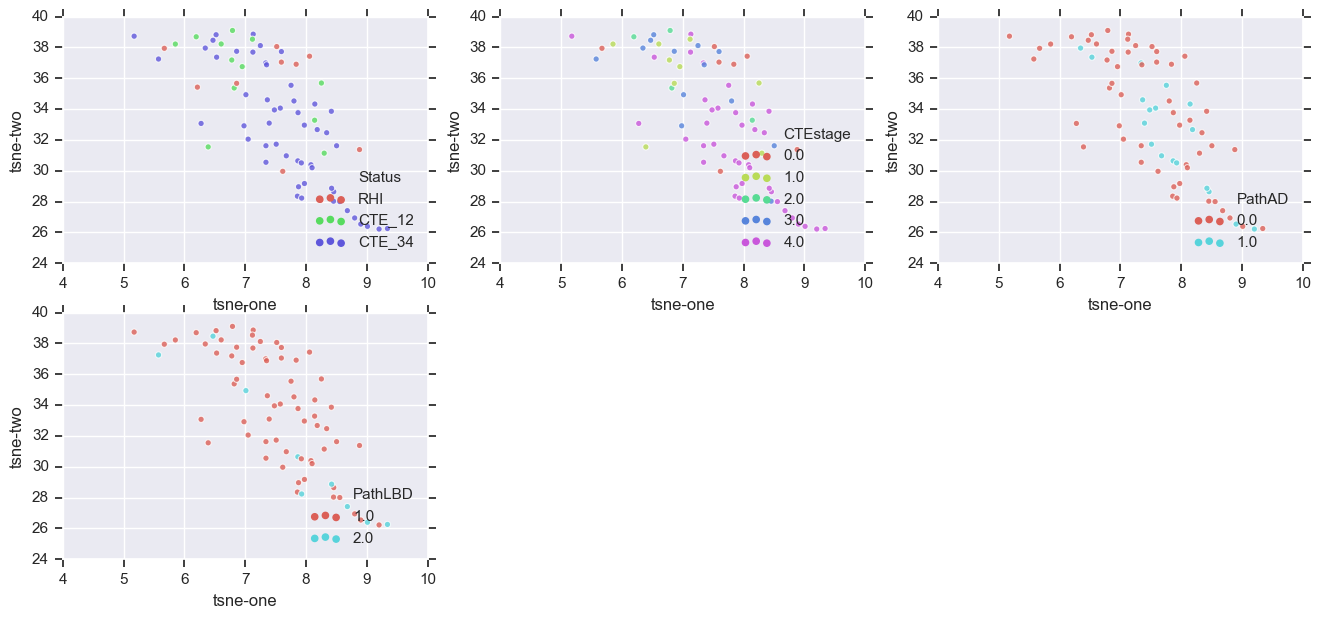

In [26]:
plt.figure(figsize=(16,7))

for i in range(len(rel_cols)):
    n = [x for x in list(x[rel_cols[i]].unique()) if str(x) != 'nan']
    ax1 = plt.subplot(2, 3, i+1)
    sns.scatterplot(
        x="tsne-one", y="tsne-two",
        hue=rel_cols[i],
        palette=sns.color_palette("hls", len(n)),
        data=x,
        alpha=0.8,
        ax=ax1
    )
#    ax1.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
    ax1.legend(loc='lower right', frameon=False)

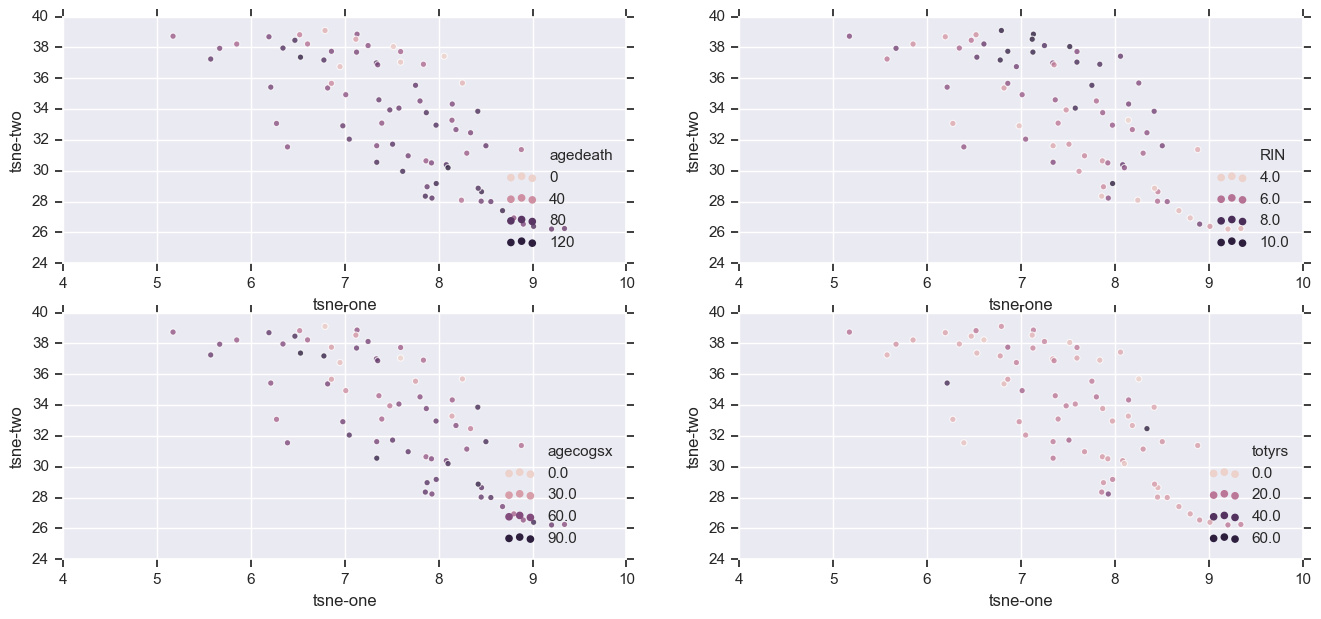

In [27]:
plt.figure(figsize=(16,7))
for i in range(len(cont_cols)):
    ax1 = plt.subplot(2, 2, i+1)
    sns.scatterplot(
        x="tsne-one", y="tsne-two",
        hue=cont_cols[i],
        data=x,
        alpha=0.8,
        ax=ax1
    )
    ax1.legend(loc='lower right', frameon=False)    

In [28]:
import statsmodels.api as sm
import scipy
from sklearn.feature_selection import chi2
col = ['agedeath', 'afe', 'AT8', 'agecogsx','totyrs', 'NeuN']
combo = list(it.combinations(col,2))
f, axs = plt.subplots(int(len(combo)),1, figsize=(6,70))
#axs = [item for l in axs for item in l]

for ax, (x,y) in zip(axs,combo):
    X = info_woc.loc[:, x]  # values converts it into a numpy array
    Y = info_woc.loc[:, y]  # -1 means that calculate the dimension of rows, but have 1 column
    mask = ~np.isnan(X) & ~np.isnan(Y)
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X[mask].values.reshape(-1, 1), Y[mask].values.reshape(-1, 1))  # perform linear regression
    Y_pred = linear_regressor.predict(X[mask].values.reshape(-1, 1))  # make predictions
    sns.scatterplot(x=x, y=y, hue="Status",data=info_woc, ax=ax)
    ax.plot(X[mask].values.reshape(-1, 1), Y_pred, color='red')
    print(x,y,linear_regressor.score(X[mask].values.reshape(-1, 1), Y[mask].values.reshape(-1, 1)))
#    print(result.summary())
#    result = sm.OLS(Y[mask].values.reshape(-1, 1),X[mask].values.reshape(-1, 1) ).fit()
#    result.summary()

/Users/Mojito/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


ImportError: cannot import name 'logsumexp'

agedeath afe 0.2204552924186349
agedeath AT8 0.3405632972890723
agedeath agecogsx 0.6645839204485257
agedeath totyrs 0.04256759111928754
agedeath NeuN 0.0746859289890438
afe AT8 0.001915039702478971
afe agecogsx 0.2316040750707018
afe totyrs 0.05965726097489077
afe NeuN 0.005316435512277118
AT8 agecogsx 0.1207036654563388
AT8 totyrs 0.15961114193442583
AT8 NeuN 0.18053820655169783
agecogsx totyrs 0.0016595675911054155
agecogsx NeuN 0.059780423337226996
totyrs NeuN 0.005079384900343653


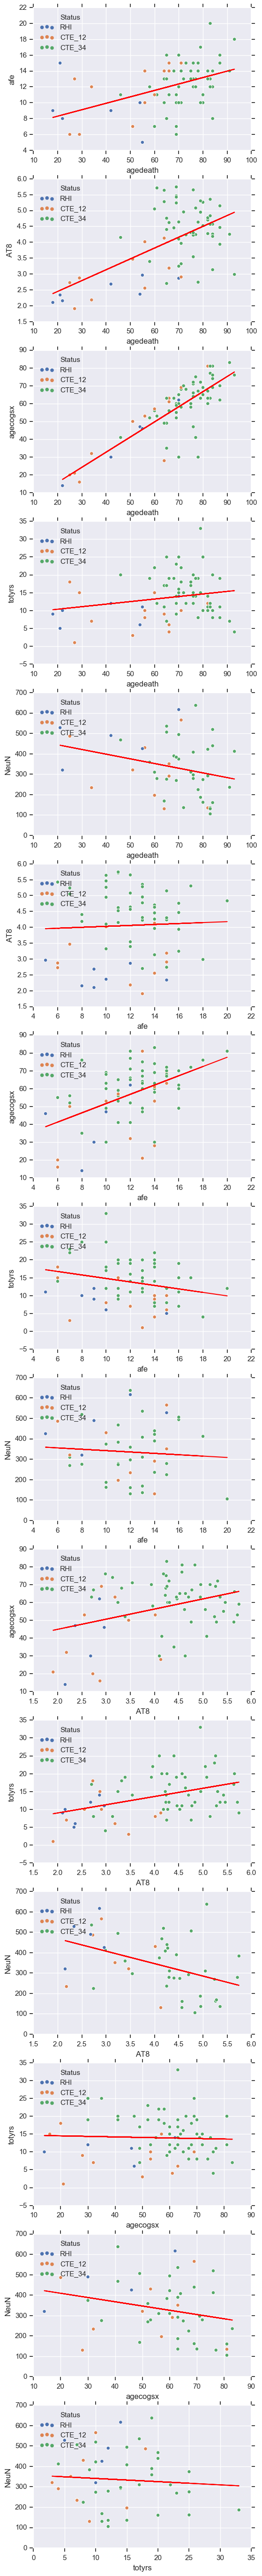

In [79]:
info_wocnt = info[info['totyrs']< 42]
col = ['agedeath', 'afe', 'AT8', 'agecogsx','totyrs', 'NeuN']
combo = list(it.combinations(col,2))
f, axs = plt.subplots(int(len(combo)),1, figsize=(6,70))
#axs = [item for l in axs for item in l]

for ax, (x,y) in zip(axs,combo):
    X = info_wocnt.loc[:, x]  # values converts it into a numpy array
    Y = info_wocnt.loc[:, y]  # -1 means that calculate the dimension of rows, but have 1 column
    mask = ~np.isnan(X) & ~np.isnan(Y)
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X[mask].values.reshape(-1, 1), Y[mask].values.reshape(-1, 1))  # perform linear regression
    Y_pred = linear_regressor.predict(X[mask].values.reshape(-1, 1))  # make predictions
    sns.scatterplot(x=x, y=y, hue="Status",data=info_wocnt, ax=ax, s=30)
    ax.plot(X[mask].values.reshape(-1, 1), Y_pred, color='red')
    ax.legend(loc='upper left', frameon=False)
    
    print(x,y,linear_regressor.score(X[mask].values.reshape(-1, 1), Y[mask].values.reshape(-1, 1)))

In [10]:
from sklearn.preprocessing import scale
# counts matrix
X = pd.read_csv("all_wocnt_all_counts_filtlow_norm_rlog.csv", index_col=0)

cnts = scale(X.values.astype(float).T)
pca = PCA(n_components=min(*cnts.shape))
pca.fit(cnts)
transformed = pca.transform(cnts)
sample_names = list(X.columns)

76 76


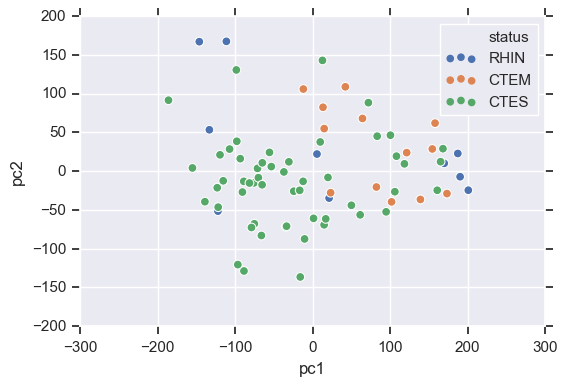

In [11]:
b = pd.DataFrame(sample_names)
b['pc1'] = transformed[:,0]
b['pc2'] = transformed[:,1]
b['status'] = b[0].str[:4]
print(len(transformed[:,0]), len(transformed[:,0]))

sns.scatterplot(b['pc1'],b['pc2'], hue="status",data=b ,s=40)

In [155]:
ensembl = pd.read_csv("../Reference/biomart_export_grch38p12.txt", sep='\t', usecols=[0,1])
ensembl.columns = ['Name', 'Gene name']

counts = pd.read_csv('all_wocnt_all_counts_filt_norm.csv', sep=',')
counts.loc[:, ['Name']] = counts['Name'].str.split('.').str[0]
counts = counts[(counts != 0).all(axis=1)]

infoc = info.set_index(['ID'])
infoc = infoc.sort_values('totyrs')
ordered = list(infoc.index)
print(len(infoc))
infoc.head()

plot_hm = pd.merge(ensembl, counts, on='Name')
plot_hm = plot_hm[list(plot_hm)[1:]]
plot_hm = plot_hm.set_index('Gene name')
plot_hm = plot_hm[ordered]
plot_hm = plot_hm.T
plot_hm['Status'] = plot_hm.index.str.split('_').str[0]

sub_type = plot_hm.pop('Status')
lut = dict(zip(sub_type.unique(), ["green","purple","yellow"]))
#lut = dict(zip(sub_type.unique(), ["green","yellow"]))
col_colors = sub_type.map(lut)
plot_hm = plot_hm.T

print(lut)

76
{'CTEM': 'green', 'CTES': 'purple', 'RHIN': 'yellow'}


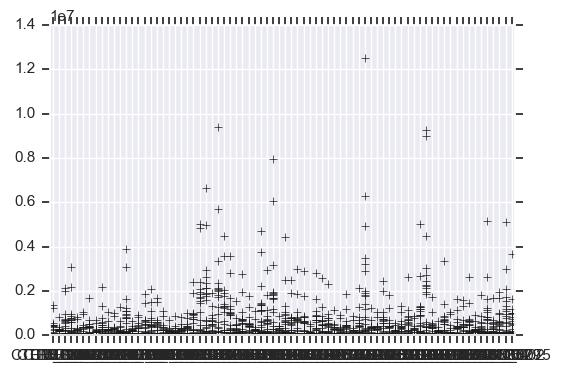

In [156]:
plot_hm.boxplot()

In [157]:
from scipy.stats import entropy
median = pd.DataFrame(plot_hm.median())
median = median.rename(columns={0:'Median'})
median['Entropy'] = entropy(plot_hm).tolist()
median = pd.merge(median, infoc, left_index=True, right_index=True)

/Users/Mojito/anaconda/lib/python3.5/site-packages/pandas/plotting/_core.py:2254: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  return_type=return_type, **kwds)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a28cb3d68>,
      dtype=object)

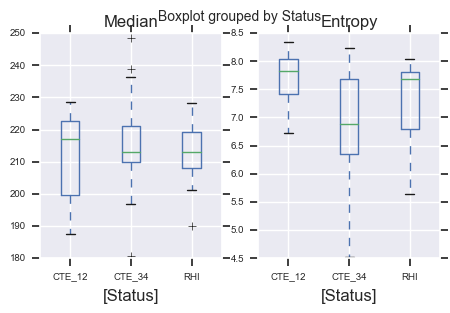

In [158]:
f, ax = plt.subplots(1,2, figsize=(5,3))
#sharex=True
median.boxplot(ax=ax, column=['Median','Entropy'], by=['Status'], fontsize=7)
#info.dropna(subset=['PathAD'])

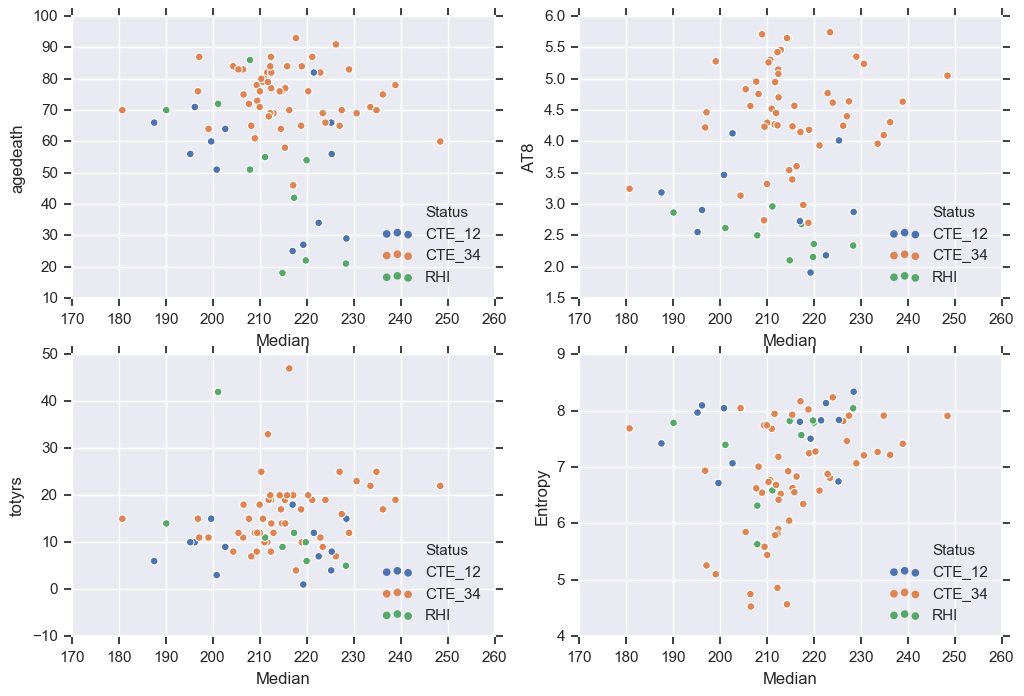

In [159]:
col = ['agedeath','AT8','totyrs', 'Entropy']
combo = list(it.combinations(col,2))
f, axs = plt.subplots(2,2, figsize=(12,8))
axs = axs.flatten()

for ax, i in zip(axs, col):
    sns.scatterplot(x='Median', y=i, data=median,hue='Status',ax=ax,s=30) 
    ax.legend(loc='lower right',frameon=False)

In [160]:
median.columns

Index(['Median', 'Entropy', 'Status', 'SampleName', 'RIN', 'Seq_Batch',
       'Diagnosis', 'CD68', 'IBA1', 'AT8', 'NeuN', 'agedeath', 'CTEstage',
       'PathAD', 'PathLBD', 'footyrs', 'agecogsx', 'totyrs', 'afe', 'sport',
       'DementiaHx', 'Race_Self_Report'],
      dtype='object')

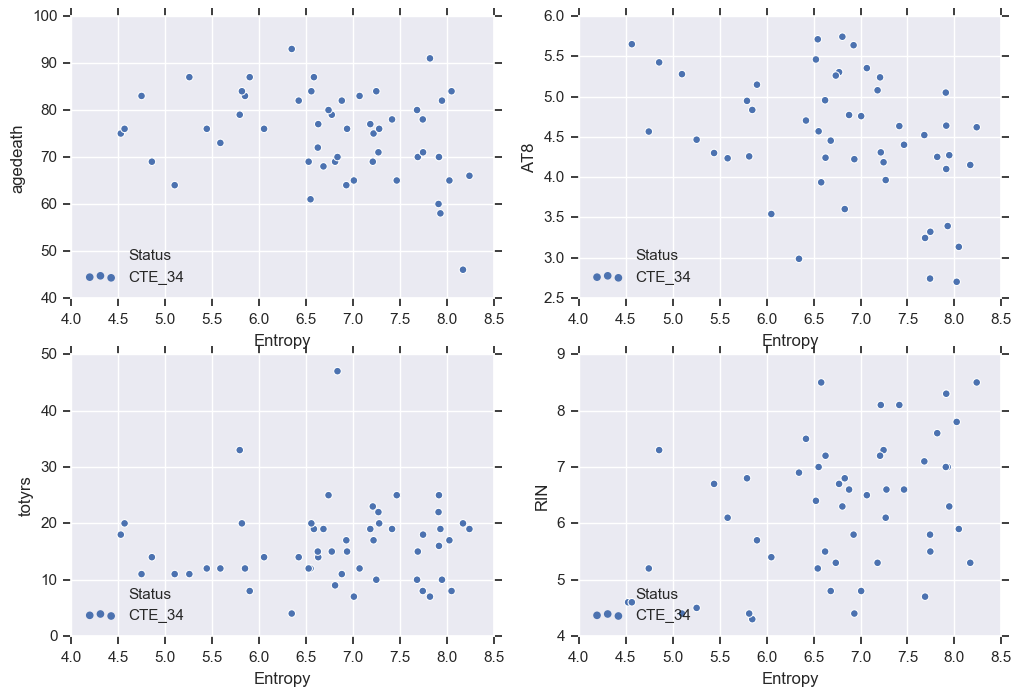

In [166]:
col = ['agedeath','AT8','totyrs', 'RIN']
combo = list(it.combinations(col,2))
f, axs = plt.subplots(2,2, figsize=(12,8))
axs = axs.flatten()
#median = median[median['Diagnosis']=='CTES']
R = median[median['Diagnosis']!='CTES']
S = median[median['Diagnosis']=='CTES']

for ax, i in zip(axs, col):
    sns.scatterplot(x='Entropy', y=i, data=S,ax=ax, hue='Status',s=30) 
    ax.legend(loc='lower left',frameon=False)

/Users/Mojito/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


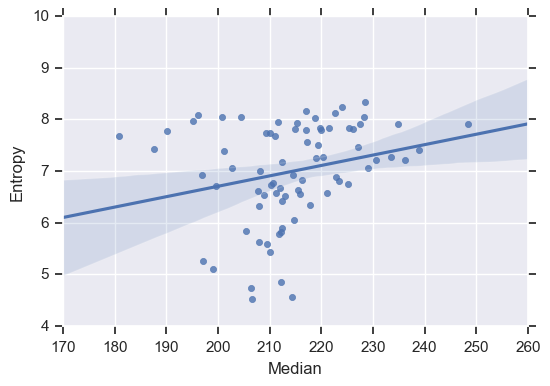

In [174]:
sns.regplot(x='Median', y='Entropy', data=median) 

/Users/Mojito/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


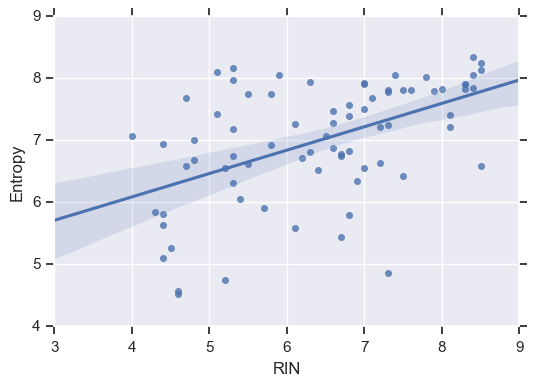

In [173]:
sns.regplot(x='RIN', y='Entropy', data=median) 

In [138]:
cnts_log = pd.read_csv('all_wocnt_all_counts_filtlow_norm_rlog.csv', sep=',')
cnts_log.loc[:, ['Unnamed: 0']] = cnts_log['Unnamed: 0'].str.split('.').str[0]
cnts_log = cnts_log.rename(columns={'Unnamed: 0':'Name'})

plotl = pd.merge(ensembl, cnts_log, on='Name')
plotl = plotl[list(plotl)[1:]]
plotl = plotl.set_index('Gene name')
plotl = plotl[ordered]
plotl = plotl.T
plotl['Status'] = plotl.index.str.split('_').str[0]

sub_type = plotl.pop('Status')
lut = dict(zip(sub_type.unique(), ["green","purple","yellow"]))
#lut = dict(zip(sub_type.unique(), ["green","yellow"]))
col_colors = sub_type.map(lut)
plotl = plotl.T

print(lut)

{'CTEM': 'green', 'CTES': 'purple', 'RHIN': 'yellow'}


(-10, 35)

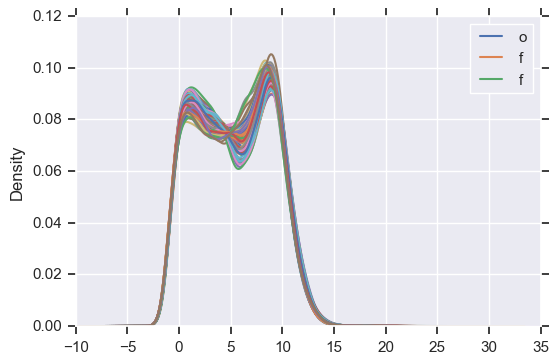

In [141]:
plotl.plot.kde()
plt.legend('off')
plt.xlim(-10,20)

In [148]:
ctes = [ _ for _ in plotl.columns if 'CTES' in _ ]
ctem = [ _ for _ in plotl.columns if 'CTEM' in _ ]
rhin = [ _ for _ in plotl.columns if 'RHI' in _ ]
print(len(ctes))

53


(-5, 15)

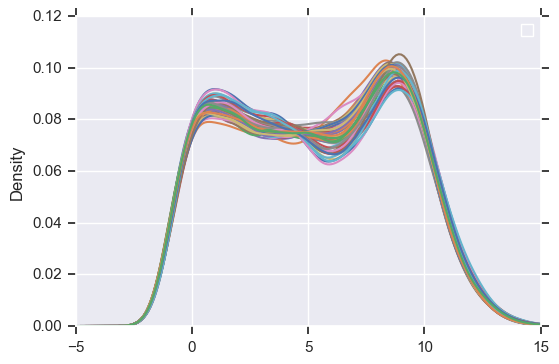

In [151]:
plotl[ctes].plot.kde()
plt.legend('')
plt.xlim(-5,15)

(-5, 15)

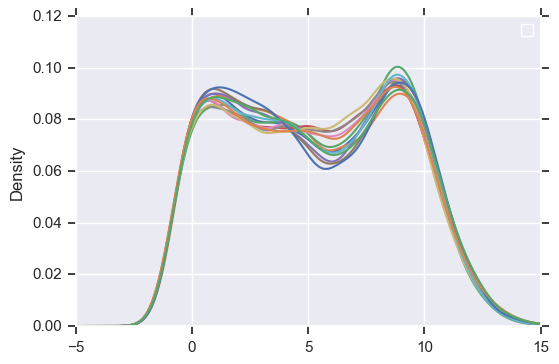

In [152]:
plotl[ctem].plot.kde()
plt.legend('')
plt.xlim(-5,15)

(-5, 15)

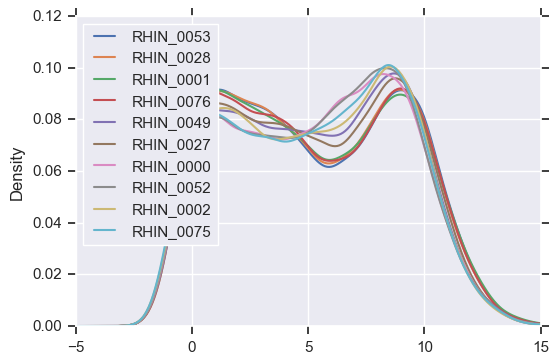

In [154]:
plotl[rhin].plot.kde()

plt.xlim(-5,15)